In [23]:
# All imports
from pathlib import Path
import warnings
from typing import Any, Tuple, Union
import cv2
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

In [24]:
BASE: Path = Path("../bleaching_data_RS")
IMG_DIR: Path = BASE / "images"
MASKS_BLEACHED_DIR: Path = BASE / "masks_bleached"
MASKS_UNBLEACHED_DIR: Path = BASE / "masks_non_bleached"


def find_mask_triple(img_path: Path) -> Union[Tuple[Path, Any, Any], Tuple[Path, None, None]]:
    """
    Group the original and mask image files based on their stem.
    The stem is the original file name without the file extension. 
    As this is the same for all 3 images, it will select them all. 

    Args:
        img_path (Path): file path of an image in the "images" folder

    Returns:
        tuple[Path, Any, Any] | tuple[Path, None, None]: tuple of file paths for all equal images (original + 2 masks)
    """
    image_stem = img_path.stem 

    bleached_path = MASKS_BLEACHED_DIR / f"{image_stem}_bleached.png"
    unbleached_path = MASKS_UNBLEACHED_DIR / f"{image_stem}_non_bleached.png"
    if bleached_path.exists() and unbleached_path.exists(): # Check that all 3 versions of the image are there, and group them
        return img_path, bleached_path, unbleached_path
    return img_path, None, None

# Build the dataset
triple: list[Any] = []
for img_path in IMG_DIR.glob("*.jpg"):
    img_path, bleached_path, non_bleached_path = find_mask_triple(img_path)
    if bleached_path is None or non_bleached_path is None:  # Warning if there is a missing mask
        print(f"[WARN] Missing masks for {img_path.name}")
        continue
    triple.append((img_path, bleached_path, non_bleached_path))

print(f"Found {len(triple)} image/mask triples.")

Found 658 image/mask triples.


In [25]:
def srgb_to_linear(color_channel_array: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
    """
    To invert the nonlinear scale, a specific formula needs to be applied based on the value of the pixel. 
    If the value is lower or equal to 0.04045, then the value should be divided by 12.92.
    If the value is higher than 0.04045, then v = ((v+0.055) / 1.055) ^ 2.4

    Args:
        color_channel_array (npt.NDArray[np.uint8]): 2D array of a color channel

    Returns:
        npt.NDArray[np.float32]: 2D array of the linearized color channel.
    """
    x = color_channel_array.astype(np.float32) / 255.0  # First convert the pixel values to [0,1] scale
    return np.where(x <= 0.04045, x / 12.92, ((x + 0.055) / 1.055) ** 2.4).astype(np.float32)

def robust_unit(x: np.ndarray, mask: np.ndarray | None) -> np.ndarray:
    # Ensure float32
    x = x.astype(np.float32, copy=False)
    H, W = x.shape[:2]

    if mask is None:
        mask = np.ones((H, W), dtype=bool)
    else:
        mask = mask.astype(bool, copy=False)
        if mask.shape[:2] != (H, W):
            mask = np.ones((H, W), dtype=bool)  # last-resort fallback

    vals = x[mask]
    vals = vals[np.isfinite(vals)]

    if vals.size < 4:
        base = x[np.isfinite(x)]
        if base.size < 4:
            return np.zeros_like(x, dtype=np.float32)
        p1, p99 = np.percentile(base, [1, 99])
    else:
        p1, p99 = np.percentile(vals, [1, 99])

    # Cast percentiles to float32 to prevent upcasting x to float64
    p1  = np.float32(p1)
    p99 = np.float32(p99)
    denom = np.float32(max(p99 - p1, 1e-6))

    # In-place normalize and clip to avoid extra big allocations
    y = x.copy()                   # one working buffer
    y -= p1                        # in-place
    y /= denom                     # in-place
    np.clip(y, 0.0, 1.0, out=y)    # in-place
    return y


def create_all_scores(bgr_img: npt.NDArray[np.uint8], all_coral_mask: npt.NDArray[np.bool_]) -> Tuple[Any, Any, Any, Any, Any, Any]:
    """
    Converts an image and its mask into all the visual traits we want to investigate. 

    Args:
        bgr_img (npt.NDArray[np.uint8]): 3D matrix of (HxWxc) with c being the color channel.
        all_coral_mask (npt.NDArray[np.bool_]): 2D matrix of all coral mask (HxW).

    Returns:
        Tuple[Any, Any, Any, Any, Any, Any]: A tuple with bgr_GW, LAB_img, raw_red_score, albedo_score, luminance_score, saturation_score.
    """
    # Convert input image to GWWB
    b, g, r = cv2.split(bgr_img.astype(np.float32))
    mean_b, mean_g, mean_r = b.mean(), g.mean(), r.mean()
    mean_value = (mean_b + mean_g + mean_r) / 3
    b *= mean_value / (mean_b + 1e-6)
    g *= mean_value / (mean_g + 1e-6)
    r *= mean_value / (mean_r + 1e-6)
    bgr_GW = cv2.merge([b, g, r])
    bgr_GW = np.clip(bgr_GW, 0, 255).astype(np.float32)

    # Convert sRGB values to a perceptually linear scale, and compute raw-red and albedo scores
    bgr_linear = srgb_to_linear(bgr_GW)
    sum_linear = bgr_linear.sum(axis=-1)
    raw_red_score = (bgr_linear[..., 2] / (sum_linear + 1e-6))  # R / (R+B+G)
    albedo_score = (sum_linear / 3.0).astype(np.float32)

    # Convert the GWWB images to CIELAB, and equalize the luminance using the CLAHE method
    LAB_img = cv2.cvtColor(bgr_GW.astype(np.uint8), cv2.COLOR_BGR2LAB) # This function requires the pixel values to be integers.
    luminance, a_channel, b_channel = cv2.split(LAB_img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    L_equalized = clahe.apply(luminance)

    # Create luminance and saturation scores, and normalize them to percentiles
    luminance_score = L_equalized.astype(np.float32) / 255
    a_channel_normalized = a_channel.astype(np.float32) - 128
    b_channel_normalized = b_channel.astype(np.float32) - 128
    saturation_score = np.sqrt(a_channel_normalized**2 + b_channel_normalized**2)
    luminance_score = robust_unit(luminance_score, all_coral_mask)
    saturation_score = robust_unit(saturation_score, all_coral_mask)

    # Ensure that only scores of coral pixels are kept. All others are set to NaN.
    for score_arr in (raw_red_score, albedo_score, luminance_score, saturation_score):
        score_arr[~all_coral_mask] = np.float32(np.nan)

    return bgr_GW, LAB_img, raw_red_score, albedo_score, luminance_score, saturation_score

In [26]:
def load_mask(path: Path, target_shape: tuple[int, int], thr: int = 128) -> Union[npt.NDArray[np.bool_], None]:
    """
    Read grayscale mask, resize to desired shape, and return a matrix with boolean entries.
    thr >= 128 = white, which means the mask is true.

    Args:
        path (Path): Path to the image in the directory
        target_shape (tuple[int, int]): Desired image shape
        thr (int, optional): Threshold for presence/absence of mask. Defaults to 128.

    Returns:
        NDArray[Any]| None: Boolean array with mask information
    """
    mask = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        warnings.warn(f"Skipping the missing mask: {path}")
        return None
    H, W = target_shape
    if mask.shape != (H, W):
        mask = cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST) # Copies the pixel value of the nearest neighbor to missing values.
    return mask >= thr

path_img, path_mb, path_mn = triple[90]
bgr_img: npt.NDArray[np.uint8] = cv2.imread(img_path) 
HEIGHT, WIDTH = bgr_img.shape[:2] 
mask_bleached = load_mask(path_mb, (HEIGHT, WIDTH))  
mask_non_bleached = load_mask(path_mn, (HEIGHT, WIDTH))
all_coral_mask = (mask_bleached | mask_non_bleached) if (mask_bleached is not None and mask_non_bleached is not None) else None

bgr_GW, LAB_img, raw_red_score, albedo_score, luminance_score, saturation_score = create_all_scores(bgr_img, all_coral_mask)

calculate_scores_per_image(bgr_img, mask_bleached, mask_non_bleached)

NameError: name 'calculate_scores_per_image' is not defined

In [28]:
def calculate_scores_per_image(bgr_img, bleached_mask, unbleached_mask): 
    all_coral_mask = (bleached_mask | unbleached_mask)

    _, _, raw_red_score, albedo_score, luminance_score, saturation_score = create_all_scores(bgr_img, all_coral_mask)
    
    features = {
        "raw_red": raw_red_score,
        "albedo": albedo_score,
        "luminance": luminance_score,
        "saturation": saturation_score,
    }
    
    out_mean = {k: float(np.nanmean(v)) for k, v in features.items()}
    out_median = {k: float(np.nanmedian(v)) for k, v in features.items()}

    return {"mean": out_mean, "median": out_median}

In [38]:
for path_img, path_mb, path_mn in triple[:10]:
    bgr_img: npt.NDArray[np.uint8] = cv2.imread(img_path) 
    HEIGHT, WIDTH = bgr_img.shape[:2]

    mask_bleached = load_mask(path_mb, (HEIGHT, WIDTH))  
    mask_non_bleached = load_mask(path_mn, (HEIGHT, WIDTH))
    all_coral_mask = (mask_bleached | mask_non_bleached)

    total_coral = int(all_coral_mask.sum())
    bleached_count = int(mask_bleached.sum())
    bleached_percentage = (bleached_count / total_coral) if total_coral > 0 else np.nan
    print(path_img.stem)

C10_BC_PM_T1_29nov24_CDaza_corr
C10_BC_PM_T2_29nov24_CDaza_corr
C10_BC_PM_T3_29nov24_CDaza_corr
C10_BC_PP_T1_29nov24_HBenavides_corr
C10_BC_PP_T2_29nov24_HBenavides_corr
C10_BC_PP_T3_29nov24_HBenavides_corr
C10_BC_PSb_T1_29nov24_HBenavides_corr
C10_BC_PSb_T2_29nov24_HBenavides_corr
C10_Gr_PM_T1_30nov24_CGomez_corr
C10_Gr_PM_T2_30nov24_CGomez_corr


In [ ]:
# Create mean and median feature score per image

import pandas as pd

rows = []
for path_img, path_mb, path_mn in triple:
    bgr_img: npt.NDArray[np.uint8] = cv2.imread(path_img) 
    HEIGHT, WIDTH = bgr_img.shape[:2]

    mask_bleached = load_mask(path_mb, (HEIGHT, WIDTH))  
    mask_non_bleached = load_mask(path_mn, (HEIGHT, WIDTH))
    all_coral_mask = (mask_bleached | mask_non_bleached)

    total_coral = int(all_coral_mask.sum())
    bleached_count = int(mask_bleached.sum())
    bleached_percentage = (bleached_count / total_coral) if total_coral > 0 else np.nan

    stats = calculate_scores_per_image(bgr_img, mask_bleached, mask_non_bleached)

    rows.append({
        "image_path": str(path_img.stem), 
        "bleached_percentage": str(bleached_percentage), 
        "mean_raw_red": stats["mean"]["raw_red"],
        "mean_albedo": stats["mean"]["albedo"],
        "mean_luminance": stats["mean"]["luminance"],
        "mean_saturation": stats["mean"]["saturation"],
        "median_raw_red": stats["median"]["raw_red"],
        "median_albedo": stats["median"]["albedo"],
        "median_luminance": stats["median"]["luminance"],
        "median_saturation": stats["median"]["saturation"],
    })

df = pd.DataFrame(rows)
df.to_csv("../feature_score_per_image.csv", index=False)
print(len(df))

C:\Users\timow\AppData\Local\Temp\ipykernel_16732\1066245440.py:13: RuntimeWarning: Mean of empty slice
  out_mean = {k: float(np.nanmean(v)) for k, v in features.items()}
C:\Users\timow\AppData\Local\Temp\ipykernel_16732\1066245440.py:14: RuntimeWarning: All-NaN slice encountered
  out_median = {k: float(np.nanmedian(v)) for k, v in features.items()}


In [ ]:
# standardize feature scores per image

import pandas as pd

df = pd.read_csv("../feature_score_per_image.csv")
# === Standardize (z-score) the feature columns ===
import json
feature_cols = [
    "mean_raw_red","mean_albedo","mean_luminance","mean_saturation",
    "median_raw_red","median_albedo","median_luminance","median_saturation",
]

# 1) Fit params on this dataframe (or your training split)
mu = df[feature_cols].mean(skipna=True)
sigma = df[feature_cols].std(ddof=0, skipna=True)  # population SD
sigma = sigma.replace(0, 1.0)  # avoid divide-by-zero if a column is constant

# 2) Transform → z-scores and append as new columns
df_z = (df[feature_cols] - mu) / sigma
df_z.columns = [c + "_z" for c in df_z.columns]
df_out = pd.concat([df, df_z], axis=1)

keep_columns = ['image_path', 'bleached_percentage', 'mean_raw_red_z',
       'mean_albedo_z', 'mean_luminance_z', 'mean_saturation_z',
       'median_raw_red_z', 'median_albedo_z', 'median_luminance_z',
       'median_saturation_z']
df_out = df_out[keep_columns]

# 3) Save CSV and the scaler params for reuse
df_out.to_csv("../standardized_feature_score_per_image.csv", index=False)
with open("../standardized_feature_score_per_image.scaler.json", "w") as f:
    json.dump({"mean": mu.to_dict(), "std": sigma.to_dict()}, f, indent=2)


In [ ]:
# check that values are standardized.
import pandas as pd
import numpy as np

csv_path = "../standardized_feature_score_per_image.csv"  # adjust
df = pd.read_csv(csv_path)

# pick only standardized feature columns
z_cols = [c for c in df.columns if c.endswith("_z")]
assert z_cols, "No standardized columns (_z) found."

# compute summary stats
means = df[z_cols].mean(skipna=True)
stds  = df[z_cols].std(ddof=0, skipna=True)  # population SD to match z-scoring

# tolerance (relaxed for finite datasets)
tol_mean = 1e-2   # |mean| should be < 0.01
tol_std  = 5e-2   # |std-1| should be < 0.05 (unless column is constant)

report = pd.DataFrame({
    "mean": means.round(6),
    "std": stds.round(6),
    "is_constant": (stds == 0.0)
})
print(report)

# flag columns outside tolerance (but ignore truly constant ones)
bad_means = means[means.abs() > tol_mean].index.tolist()
bad_stds  = [c for c in z_cols if (not report.loc[c, "is_constant"]) and abs(stds[c] - 1.0) > tol_std]

print("\nIssues:")
print(" mean not ~0:", bad_means or "OK")
print(" std not ~1:", bad_stds or "OK")

# Optional: quick NA check
na_counts = df[z_cols].isna().sum()
print("\nNaNs per column:")
print(na_counts[na_counts > 0])


                     mean  std  is_constant
mean_raw_red_z       -0.0  1.0        False
mean_albedo_z         0.0  1.0        False
mean_luminance_z     -0.0  1.0        False
mean_saturation_z    -0.0  1.0        False
median_raw_red_z     -0.0  1.0        False
median_albedo_z      -0.0  1.0        False
median_luminance_z   -0.0  1.0        False
median_saturation_z  -0.0  1.0        False

Issues:
 mean not ~0: OK
 std not ~1: OK

NaNs per column:
mean_raw_red_z         24
mean_albedo_z          24
mean_luminance_z       24
mean_saturation_z      24
median_raw_red_z       24
median_albedo_z        24
median_luminance_z     24
median_saturation_z    24
dtype: int64


In [16]:
for column in df_out.columns[1:]:
    print(df_out[column].mean())

0.3461346153393153
0.11604128574676313
0.3705855264366613
0.22333530082781608
0.3461499886839924
0.08930259166808342
0.31989478529063686
0.1699087566781307
-1.5501094974734836e-15
3.2781348613537744e-16
-5.743740569038665e-16
-8.069255043332368e-16
-1.5907359551569277e-15
-2.521642201041365e-17
-8.559574360201522e-16
-5.2113938821521545e-16


C:\Users\timow\AppData\Local\Temp\ipykernel_12248\1066245440.py:13: RuntimeWarning: Mean of empty slice
  out_mean = {k: float(np.nanmean(v)) for k, v in features.items()}
C:\Users\timow\AppData\Local\Temp\ipykernel_12248\1066245440.py:14: RuntimeWarning: All-NaN slice encountered
  out_median = {k: float(np.nanmedian(v)) for k, v in features.items()}


658


In [11]:
def create_ECDFs(path_triples: list[tuple[Path, Path, Path]])-> dict[str, npt.NDArray[np.float32]]: 
    """
    For each image in the given dataset, the whiteness score is calculated for the coral pixels.
    Outliers (= values outside winsorization range) are clipped. 
    Then a histogram of the whiteness values is created. 
    Input setting "weighting" decides if all pixels have equal weight, or if all images do.
    Then an ECDF is created from all histograms.

    Args:
        path_triples (list[tuple[Path, Path, Path]]): Paths to the images.

    Raises:
        ValueError: Raise error if empty score array is found.

    Returns:
        dict[str, npt.NDArray[np.float32]]: Dictionary with bin edges and cdfs of each score.
    """
    # Iterate over all images in the given dataset
    for img_path, mb_path, mn_path in path_triples:
        img_bgr: npt.NDArray[np.uint8] = cv2.imread(str(img_path), cv2.IMREAD_COLOR)            
        img_HEIGHT, img_WIDTH = img_bgr.shape[:2]           

        # Load masks and create coral mask.
        mask_bleached = load_mask(mb_path, (img_HEIGHT, img_WIDTH))
        mask_non_bleached = load_mask(mn_path, (img_HEIGHT, img_WIDTH))
        all_coral_mask: npt.NDArray[np.bool_] = (mask_bleached | mask_non_bleached) if (mask_bleached is not None and mask_non_bleached is not None) else None          
        if all_coral_mask is None or not all_coral_mask.any():
            continue
        
        # Calculate all scores
        _, _, raw_red_score, albedo_score, luminance_score, saturation_score = create_all_scores(img_bgr, all_coral_mask)


        def get_ecdf(score: npt.NDArray[np.float32]) -> Tuple[npt.NDArray[np.float32], npt.NDArray[np.float32]]:
            # Initialize variables
            nr_of_bins = 4096
            bin_heights = np.zeros(nr_of_bins, dtype=np.float64)
            bin_edges = None

            # 1D matrix of whiteness scores, excludes 0 values of non coral pixels
            score_flattened = score[all_coral_mask]  # coral-only 1D
            if score_flattened.size == 0:
                raise ValueError(f"Empty score array detected.")

            # Values outside the winsor range get clipped to the nearst number in the range (to prevfent extreme points from dominating the histogram)
            lo, hi = np.percentile(score_flattened, (0.05, 0.95))
            score_flattened = np.clip(score_flattened, lo, hi)

            # bin_edges stores the bin edges as an 1D array. 
            count, bin_edges = np.histogram(score_flattened, bins=nr_of_bins, range=(0.0, 1.0))

            # Each image has the same influence on the ECDF. Big images will have the same influence as small images.
            sum = count.sum()
            if sum > 0:
                bin_heights += count / sum

            # Sum all histograms, and normalize to keep the whiteness scores in [0,1]
            cdf = np.cumsum(bin_heights) / bin_heights.sum()
            return (bin_edges, cdf)
    
    # Create separate ECDF for each score
    raw_red_bin_edges, raw_red_cdf = get_ecdf(raw_red_score)
    print("raw red done")
    albedo_bin_edges, albedo_cdf = get_ecdf(albedo_score)
    print("albedo done")
    luminance_bin_edges, luminance_cdf = get_ecdf(luminance_score)
    print("luminance done")
    saturation_bin_edges, saturation_cdf = get_ecdf(saturation_score)

    # Save cdf and input values as a dictionary
    return {"raw_red_bin_edges": raw_red_bin_edges, "raw_red_cdf": raw_red_cdf, 
            "albedo_bin_edges": albedo_bin_edges, "albedo_cdf": albedo_cdf, 
            "luminance_bin_edges": luminance_bin_edges, "luminance_cdf": luminance_cdf, 
            "saturation_bin_edges": saturation_bin_edges, "saturation_cdf": saturation_cdf}

In [12]:
def load_mask(path: Path, target_shape: tuple[int, int], thr: int = 128) -> Union[npt.NDArray[np.bool_], None]:
    """
    Read grayscale mask, resize to desired shape, and return a matrix with boolean entries.
    thr >= 128 = white, which means the mask is true.

    Args:
        path (Path): Path to the image in the directory
        target_shape (tuple[int, int]): Desired image shape
        thr (int, optional): Threshold for presence/absence of mask. Defaults to 128.

    Returns:
        NDArray[Any]| None: Boolean array with mask information
    """
    mask = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        warnings.warn(f"Skipping the missing mask: {path}")
        return None
    H, W = target_shape
    if mask.shape != (H, W):
        mask = cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST) # Copies the pixel value of the nearest neighbor to missing values.
    return mask >= thr

Correlations with each visual trait

Exact Pearson computed over ~1,991,056,507 coral pixels.

Pearson correlation:
             raw_red  albedo  luminance  saturation
raw_red       1.000  -0.193     -0.084       0.013
albedo       -0.193   1.000      0.798       0.521
luminance    -0.084   0.798      1.000       0.451
saturation    0.013   0.521      0.451       1.000

Spearman (on reservoir sample):
             raw_red  albedo  luminance  saturation
raw_red       1.000  -0.155     -0.080       0.172
albedo       -0.155   1.000      0.883       0.346
luminance    -0.080   0.883      1.000       0.374
saturation    0.172   0.346      0.374       1.000


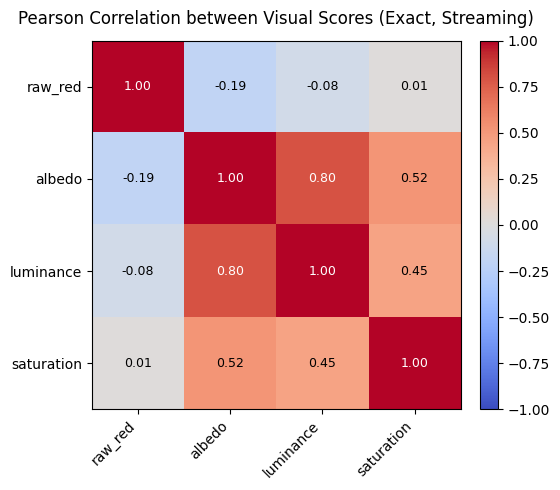

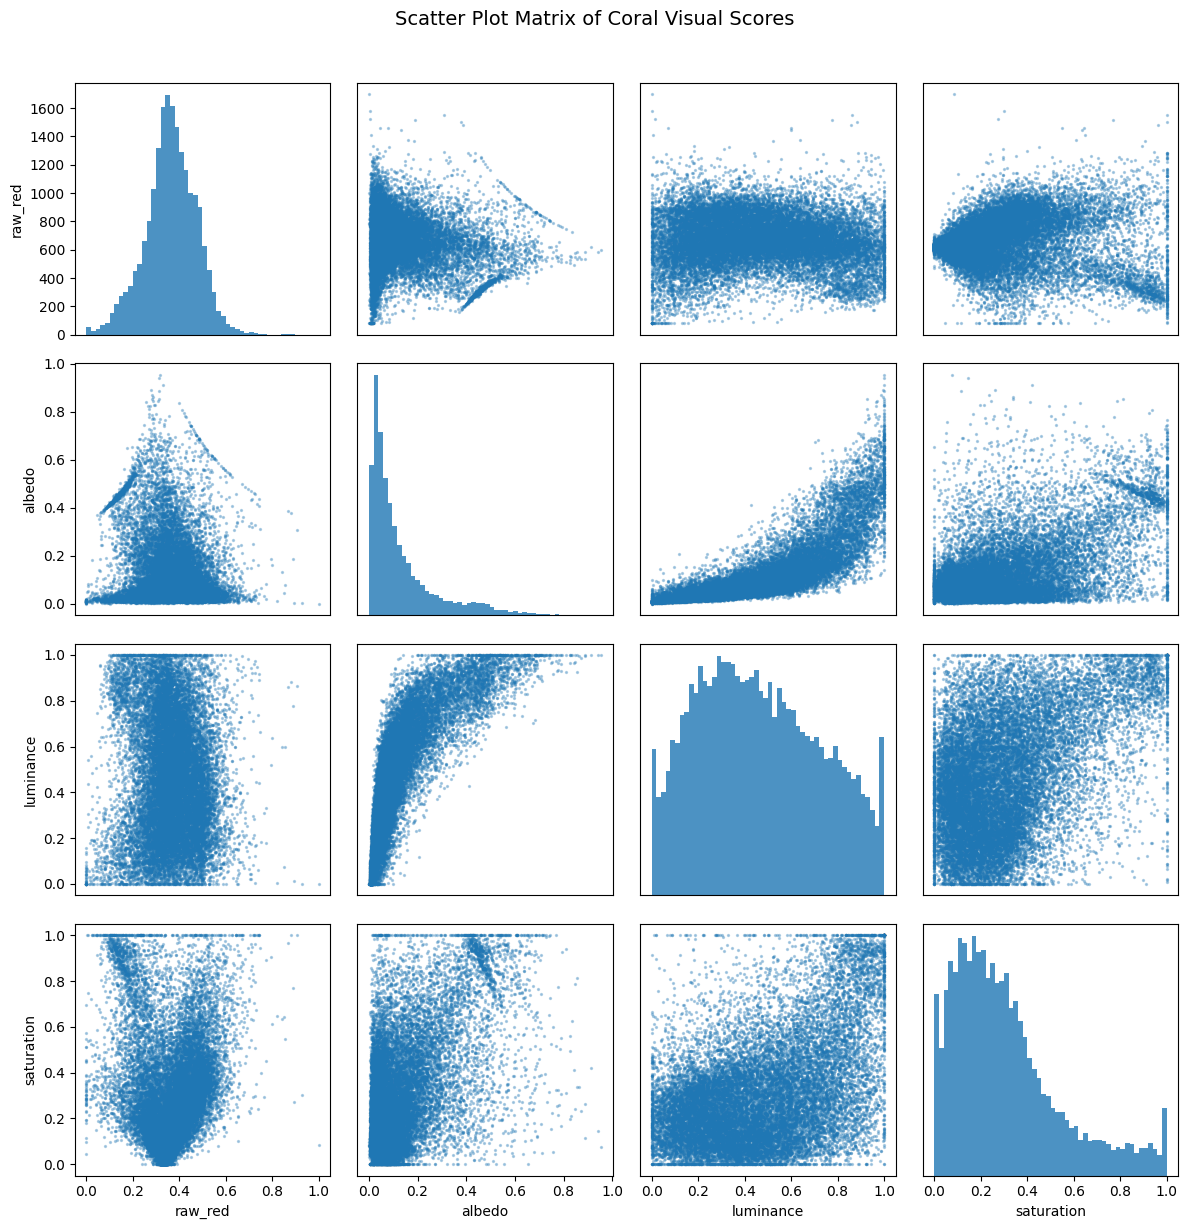

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ===============================
# Streaming Pearson + Reservoir
# ===============================

def stream_pearson_and_reservoir(
    path_triples,
    reservoir_cap=150_000,         # how many points to keep for scatter plots
    random_state=42,
    spearman_on_reservoir=True     # optional sampled Spearman on the reservoir
):
    """
    One-pass exact Pearson correlation over all valid coral pixels (no sampling),
    plus a uniform reservoir for visualization.

    Returns:
        pearson_df: 4x4 DataFrame of exact Pearson correlations
        sample_df:  DataFrame of reservoir sample (for scatter matrix)
        spearman_df: Spearman on the reservoir (or None)
        n_total: total number of coral pixels used
    """
    rng = np.random.default_rng(random_state)

    # We’ll track sums for mean and covariance:
    # For 4 variables (RR, AL, LU, SA), we need sum(x), sum(x^2), and sum(xy) for each pair.
    names = ["raw_red", "albedo", "luminance", "saturation"]
    k = len(names)

    n_total = 0
    sum_x  = np.zeros(k, dtype=np.float64)
    sum_x2 = np.zeros(k, dtype=np.float64)
    sum_xy = np.zeros((k, k), dtype=np.float64)

    # Reservoir buffers for plotting
    res = {name: [] for name in names}
    res_count = 0  # total items seen for reservoir replacement

    def add_to_stream(rr, al, lu, sa):
        nonlocal n_total, sum_x, sum_x2, sum_xy, res_count

        X = np.stack([rr, al, lu, sa], axis=1).astype(np.float64, copy=False)
        # Remove any leftover non-finite (should be rare)
        ok = np.isfinite(X).all(axis=1)
        if not ok.any():
            return
        X = X[ok]
        m = X.shape[0]
        if m == 0:
            return

        # Update totals
        n_total += m
        sum_x  += X.sum(axis=0)
        sum_x2 += (X * X).sum(axis=0)
        sum_xy += X.T @ X

        # Reservoir sampling (Vitter’s algorithm R)
        for row in X:
            res_count += 1
            if len(res[names[0]]) < reservoir_cap:
                for i, name in enumerate(names):
                    res[name].append(row[i])
            else:
                j = rng.integers(0, res_count)
                if j < reservoir_cap:
                    for i, name in enumerate(names):
                        res[name][j] = row[i]

    # ==== Stream over dataset ====
    for img_path, mb_path, mn_path in path_triples:
        img_bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        if img_bgr is None:
            continue
        H, W = img_bgr.shape[:2]

        mask_b = load_mask(mb_path, (H, W))
        mask_n = load_mask(mn_path, (H, W))
        if mask_b is None and mask_n is None:
            continue
        coral_mask = (mask_b if mask_b is not None else np.zeros((H, W), bool)) | \
                     (mask_n if mask_n is not None else np.zeros((H, W), bool))
        if not coral_mask.any():
            continue

        _, _, raw_red, albedo, luminance, saturation = create_all_scores(img_bgr, coral_mask)

        rr = raw_red[coral_mask]
        al = albedo[coral_mask]
        lu = luminance[coral_mask]
        sa = saturation[coral_mask]

        # filter invalids per-variable
        valid = np.isfinite(rr) & np.isfinite(al) & np.isfinite(lu) & np.isfinite(sa)
        if not valid.any():
            continue

        add_to_stream(rr[valid], al[valid], lu[valid], sa[valid])

    if n_total == 0:
        raise ValueError("No valid coral pixels found across the dataset.")

    # ==== Exact Pearson from streaming stats ====
    mean = sum_x / n_total
    # Var = E[X^2] - (E[X])^2
    ex2 = sum_x2 / n_total
    var = ex2 - mean * mean
    std = np.sqrt(np.maximum(var, 0.0))
    # Cov = E[XY] - E[X]E[Y]
    exy = sum_xy / n_total
    cov = exy - np.outer(mean, mean)
    denom = np.outer(std, std)
    with np.errstate(invalid="ignore", divide="ignore"):
        pearson = cov / denom
    # Clean up any 0-variance issues (NaNs)
    pearson = np.where(np.isfinite(pearson), pearson, 0.0)
    pearson_df = pd.DataFrame(pearson, index=names, columns=names)

    # Reservoir sample DataFrame
    sample_df = pd.DataFrame({name: np.array(vals, dtype=np.float32) for name, vals in res.items()})

    # Optional Spearman on the reservoir
    if spearman_on_reservoir and len(sample_df) > 1:
        spearman_df = sample_df.corr(method="spearman")
    else:
        spearman_df = None

    return pearson_df, sample_df, spearman_df, n_total


# ===============================
# Plotting helpers
# ===============================

def plot_correlation_heatmap(corr_df, title="Correlation Heatmap"):
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(corr_df, vmin=-1, vmax=1, cmap="coolwarm")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_xticks(np.arange(len(corr_df.columns)))
    ax.set_yticks(np.arange(len(corr_df.index)))
    ax.set_xticklabels(corr_df.columns, rotation=45, ha="right", fontsize=10)
    ax.set_yticklabels(corr_df.index, fontsize=10)
    for i in range(len(corr_df)):
        for j in range(len(corr_df.columns)):
            v = corr_df.iloc[i, j]
            ax.text(j, i, f"{v:.2f}", ha="center", va="center",
                    color="white" if abs(v) > 0.7 else "black", fontsize=9)
    ax.set_title(title, fontsize=12, pad=12)
    plt.tight_layout()
    plt.show()


def plot_scatter_matrix(df, sample=20000):
    # For plotting speed, downsample the reservoir if it’s huge
    if len(df) > sample:
        df = df.sample(sample, random_state=42)
    cols = df.columns
    n = len(cols)
    fig, axes = plt.subplots(n, n, figsize=(3*n, 3*n))
    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            if i == j:
                ax.hist(df[cols[i]], bins=50, alpha=0.8)
            else:
                ax.scatter(df[cols[j]], df[cols[i]], s=2, alpha=0.3)
            if i == n - 1:
                ax.set_xlabel(cols[j], fontsize=10)
            else:
                ax.set_xticks([])
            if j == 0:
                ax.set_ylabel(cols[i], fontsize=10)
            else:
                ax.set_yticks([])
    plt.suptitle("Scatter Plot Matrix of Coral Visual Scores", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


# ===============================
# Run it
# ===============================
pearson_df, sample_df, spearman_df, n_used = stream_pearson_and_reservoir(
    test_set,
    reservoir_cap=150_000,        # tweak as you like for smoother plots
    random_state=42,
    spearman_on_reservoir=True
)

print(f"Exact Pearson computed over ~{n_used:,} coral pixels.")
print("\nPearson correlation:\n", pearson_df.round(3))
if spearman_df is not None:
    print("\nSpearman (on reservoir sample):\n", spearman_df.round(3))

plot_correlation_heatmap(pearson_df, "Pearson Correlation between Visual Scores (Exact, Streaming)")
plot_scatter_matrix(sample_df)


Correlation between each trait and bleaching. 
And an ROC curve for each of the features.
And a violin plot for the feature score distributions of the bleached and non-bleached pixels. 

In [46]:
# === All-in-one: ROC (streaming, all pixels) + low-FPR zoom + combined violins + ALL-PIXELS correlations ===
# Assumes you already defined:
#   - triple  -> list of (img_path, bleached_mask_path, non_bleached_mask_path)
#   - create_all_scores(img, mask) -> returns (..., raw_red, albedo, luminance, saturation)
from pathlib import Path
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# -------------------- CONFIG (edit these) --------------------
N_FIRST = None                   # <--- set to 5 for a quick test; use None to run on all images
OUT_DIR = BASE if 'BASE' in globals() else Path("./outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

NUM_BINS = 2048               # histogram bins for ROC (AUC smoothness)
LOW_FPR_MAX = 0.01            # partial AUC window (1% FPR)
ORIENT_SAMPLE_TOTAL = 1_000_000  # labeled pixels used only to decide orientation sign
VIOLIN_SAMPLES_PER_CLASS_TOTAL = 400_000  # per feature, per class, for violins (keeps fig light)
SEED = 123
rng = np.random.default_rng(SEED)

# -------------------- SANITY CHECKS --------------------
for name in ("triple", "create_all_scores"):
    if name not in globals():
        raise RuntimeError(f"Required global '{name}' is not defined.")

# -------------------- HELPERS --------------------
def read_image_and_masks(img_p: Path, bleached_p: Path, unbleached_p: Path):
    img = cv2.imread(str(img_p), cv2.IMREAD_COLOR)
    if img is None:
        raise RuntimeError(f"Failed to read image: {img_p}")
    mb = cv2.imread(str(bleached_p), cv2.IMREAD_GRAYSCALE)
    mu = cv2.imread(str(unbleached_p), cv2.IMREAD_GRAYSCALE)
    if mb is None or mu is None:
        raise RuntimeError(f"Failed to read masks for: {img_p.stem}")
    H, W = img.shape[:2]
    if mb.shape[:2] != (H, W): mb = cv2.resize(mb, (W, H), interpolation=cv2.INTER_NEAREST)
    if mu.shape[:2] != (H, W): mu = cv2.resize(mu, (W, H), interpolation=cv2.INTER_NEAREST)
    mb = (mb > 127); mu = (mu > 127)
    valid = mb | mu
    y = np.where(mb, 1, 0).astype(np.uint8)  # overlaps => bleached
    return img, y, valid

# Running stats for exact point-biserial correlation (all pixels)
from dataclasses import dataclass
@dataclass
class RunningStats:
    n: int = 0
    mean: float = 0.0
    M2: float = 0.0  # sum of squares of diffs from current mean

def update_stats_batch(rs: RunningStats, arr: np.ndarray) -> RunningStats:
    arr = np.asarray(arr, np.float64)
    arr = arr[np.isfinite(arr)]
    n = arr.size
    if n == 0:
        return rs
    mean = float(arr.mean())
    M2 = float(((arr - mean) ** 2).sum())
    if rs.n == 0:
        return RunningStats(n=n, mean=mean, M2=M2)
    delta = mean - rs.mean
    tot = rs.n + n
    new_mean = rs.mean + delta * (n / tot)
    new_M2 = rs.M2 + M2 + (delta * delta) * (rs.n * n / tot)
    return RunningStats(n=tot, mean=new_mean, M2=new_M2)

def roc_from_hist(pos_h: np.ndarray, neg_h: np.ndarray, fpr_max: float):
    """Return fpr, tpr, auc, partial_auc(low-FPR) from class histograms."""
    P = pos_h.astype(np.float64); N = neg_h.astype(np.float64)
    Psum, Nsum = P.sum(), N.sum()
    if Psum == 0 or Nsum == 0:
        return np.array([0.0, 1.0]), np.array([0.0, 1.0]), np.nan, np.nan
    tp = np.cumsum(P[::-1]); fp = np.cumsum(N[::-1])  # sweep high->low threshold
    tpr = tp / Psum; fpr = fp / Nsum
    fpr = np.concatenate(([0.0], fpr)); tpr = np.concatenate(([0.0], tpr))
    auc = float(np.trapz(tpr, fpr))
    m = fpr <= fpr_max
    pauc = float(np.trapz(tpr[m], fpr[m]) / max(fpr[m][-1] - fpr[m][0], 1e-12)) if np.any(m) else np.nan
    return fpr, tpr, auc, pauc

# -------------------- DATASET SELECTION --------------------
use_triples = triple[:N_FIRST] if N_FIRST is not None else triple
if not use_triples:
    raise RuntimeError("No image/mask triples to process.")
features = ["raw_red", "albedo", "luminance", "saturation"]

# -------------------- PASS 1: Orientation from a small sample --------------------
# Decide sign per feature so that "higher = bleached" for plotting/ROC. Uses a light sample.
orient_buf = {f: [] for f in features}
y_orient = []
seen = 0
per_img_cap = max(10_000, ORIENT_SAMPLE_TOTAL // max(1, len(use_triples)))

for (img_p, b_p, u_p) in use_triples:
    if seen >= ORIENT_SAMPLE_TOTAL: break
    img, y, valid = read_image_and_masks(img_p, b_p, u_p)
    m = valid.ravel()
    y1 = y.ravel()[m]
    if y1.size == 0: continue
    k = min(per_img_cap, ORIENT_SAMPLE_TOTAL - seen, y1.size)
    idx = rng.choice(y1.size, size=k, replace=False)

    # Build features once
    _, _, raw_red, albedo, luminance, saturation = create_all_scores(img, valid)
    fmap = {"raw_red": raw_red, "albedo": albedo, "luminance": luminance, "saturation": saturation}
    for f in features:
        s = np.asarray(fmap[f], np.float32).ravel()[m][idx]
        orient_buf[f].append(s[np.isfinite(s)])
    y_orient.append(y1[idx])
    seen += k

y_orient = np.concatenate(y_orient) if len(y_orient) else np.array([], np.uint8)
if y_orient.size == 0:
    raise RuntimeError("No labeled pixels in orientation sample.")

# (fast AUC sign check using np.trapz on histograms from the sample)
sign = {}
for f in features:
    s = np.concatenate(orient_buf[f]) if orient_buf[f] else np.array([], np.float32)
    if s.size == 0:
        sign[f] = +1
        continue
    # quick AUC via small hist
    edges_tmp = np.linspace(0.0, 1.0, 512+1)  # original features in [0,1]
    pos = y_orient == 1
    h_pos = np.histogram(s[pos], bins=edges_tmp)[0].astype(float)
    h_neg = np.histogram(s[~pos], bins=edges_tmp)[0].astype(float)
    _, _, auc_tmp, _ = roc_from_hist(h_pos, h_neg, LOW_FPR_MAX)
    sign[f] = -1 if (np.isfinite(auc_tmp) and auc_tmp < 0.5) else +1

# -------------------- PASS 2: Streaming histograms (ROC), ALL-PIXELS correlations, and violin sampling --------------------
edges = np.linspace(-1.0, 1.0, NUM_BINS + 1, dtype=np.float64)  # after sign flip scores ∈ [-1,1]
pos_hist = {f: np.zeros(NUM_BINS, dtype=np.int64) for f in features}
neg_hist = {f: np.zeros(NUM_BINS, dtype=np.int64) for f in features}

# Running stats for exact point-biserial on ORIGINAL (unflipped) features
stats_all = {f: RunningStats() for f in features}
stats_pos = {f: RunningStats() for f in features}
stats_neg = {f: RunningStats() for f in features}

# Violin sampling buffers (on ORIENTED scores, for visuals only)
n_img = len(use_triples)
violin_per_img = max(1, VIOLIN_SAMPLES_PER_CLASS_TOTAL // max(1, n_img))
violin_samples = {f: {0: [], 1: []} for f in features}

total_pos = total_neg = 0

for (img_p, b_p, u_p) in use_triples:
    img, y, valid = read_image_and_masks(img_p, b_p, u_p)
    m = valid.ravel()
    y1 = y.ravel()[m]
    if y1.size == 0: continue

    # Compute features once for this image
    _, _, raw_red, albedo, luminance, saturation = create_all_scores(img, valid)
    fmap = {"raw_red": raw_red, "albedo": albedo, "luminance": luminance, "saturation": saturation}

    pos = (y1 == 1)
    neg = ~pos
    total_pos += int(pos.sum()); total_neg += int(neg.sum())

    for f in features:
        # ORIGINAL for correlations:
        x = np.asarray(fmap[f], np.float32).ravel()[m]

        # Update running stats (ALL pixels)
        stats_all[f] = update_stats_batch(stats_all[f], x)
        stats_pos[f] = update_stats_batch(stats_pos[f], x[pos])
        stats_neg[f] = update_stats_batch(stats_neg[f], x[neg])

        # ORIENTED for ROC/violins:
        s_or = sign[f] * x
        s_or = np.clip(s_or, -1.0, 1.0)

        # Update streaming histograms
        if pos.any():
            pos_hist[f] += np.histogram(s_or[pos], bins=edges)[0]
        if neg.any():
            neg_hist[f] += np.histogram(s_or[neg],  bins=edges)[0]

        # Violin sampling (keep figs light)
        for cls, mask in ((0, neg), (1, pos)):
            n_avail = int(mask.sum())
            if n_avail <= 0: continue
            k = min(violin_per_img, n_avail)
            sel = rng.choice(np.flatnonzero(mask), size=k, replace=False)
            violin_samples[f][cls].append(s_or[sel])

# Concatenate violin samples
for f in features:
    violin_samples[f][0] = np.concatenate(violin_samples[f][0]) if violin_samples[f][0] else np.array([], np.float32)
    violin_samples[f][1] = np.concatenate(violin_samples[f][1]) if violin_samples[f][1] else np.array([], np.float32)

# -------------------- ROC from histograms (ALL pixels) --------------------
roc_curves = {f: roc_from_hist(pos_hist[f], neg_hist[f], LOW_FPR_MAX) for f in features}

# -------------------- PLOTS --------------------
# 1) Full ROC
plt.figure(figsize=(7, 7))
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
for f in features:
    fpr, tpr, auc, pauc = roc_curves[f]
    flip_note = " • flipped" if sign[f] == -1 else ""
    plt.plot(fpr, tpr, label=f"{f} (AUC={auc:.3f}{flip_note})", linewidth=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves (streaming, pooled pixels; higher = bleached)")
plt.legend(loc="lower right")
plt.tight_layout()
roc_path = OUT_DIR / "ROC_curves.png"
plt.savefig(roc_path, dpi=150); plt.close()
print(f"Saved: {roc_path}")

# 2) Low-FPR zoom
plt.figure(figsize=(7, 7))
for f in features:
    fpr, tpr, auc, pauc = roc_curves[f]
    m = fpr <= LOW_FPR_MAX
    plt.plot(fpr[m], tpr[m], label=f"{f} (pAUC@{int(LOW_FPR_MAX*100)}%={pauc:.3f})", linewidth=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title(f"ROC (zoomed to FPR ≤ {int(LOW_FPR_MAX*100)}%)")
plt.legend(loc="lower right")
plt.tight_layout()
roc_zoom_path = OUT_DIR / "ROC_lowFPR_zoom.png"
plt.savefig(roc_zoom_path, dpi=150); plt.close()
print(f"Saved: {roc_zoom_path}")

# 3) Combined 2x2 violin plots (oriented scores; higher = bleached)
fig, axes = plt.subplots(2, 2, figsize=(11, 9), sharey=False)
axes = axes.ravel()
for ax, f in zip(axes, features):
    s0 = violin_samples[f][0]; s1 = violin_samples[f][1]
    # robust y-limits
    if s0.size + s1.size > 0:
        lo, hi = np.nanpercentile(np.concatenate([s0, s1]), [0.5, 99.5])
        pad = 0.05 * (hi - lo + 1e-12)
        ax.set_ylim(lo - pad, hi + pad)
    ax.violinplot([s0, s1], positions=[0, 1], showmeans=True, widths=0.9)
    ax.boxplot([s0, s1], positions=[0, 1], widths=0.18)
    ax.set_xticks([0, 1], ["healthy", "bleached"])
    ax.set_ylabel("score (higher = bleached)")
    flip_note = " (flipped for plotting)" if sign[f] == -1 else ""
    _, _, auc, pauc = roc_curves[f]
    ax.set_title(f"{f}{flip_note}\nROC-AUC={auc:.3f}  •  pAUC@1%={pauc:.3f}")
fig.suptitle("Feature distributions by class")
plt.tight_layout(rect=[0, 0, 1, 0.96])
violins_path = OUT_DIR / "violins_all_features.png"
plt.savefig(violins_path, dpi=150); plt.close()
print(f"Saved combined violin figure → {violins_path}")

# -------------------- ALL-PIXELS CORRELATIONS --------------------
# Exact point-biserial Pearson r using running stats; nonparametric rank-biserial δ from AUC.
rows = []
for f in features:
    n_pos = stats_pos[f].n
    n_neg = stats_neg[f].n
    n_all = stats_all[f].n
    if n_all < 2 or n_pos == 0 or n_neg == 0:
        r_pb = np.nan
    else:
        p = n_pos / n_all
        q = 1.0 - p
        mu1 = stats_pos[f].mean
        mu0 = stats_neg[f].mean
        var_all = stats_all[f].M2 / max(n_all - 1, 1)  # sample variance
        sx = float(np.sqrt(max(var_all, 1e-12)))
        r_pb = ((mu1 - mu0) / sx) * np.sqrt(max(p * q, 0.0))  # point-biserial (Pearson with 0/1 label)

    # AUC & partial AUC already from ALL pixels via hist
    auc = roc_curves[f][2]
    pauc = roc_curves[f][3]
    delta = 2.0 * auc - 1.0  # rank-biserial effect size ∈ [-1,1]

    rows.append({
        "feature": f,
        "ROC_AUC_streaming": auc,
        f"partial_AUC_FPR<={int(LOW_FPR_MAX*100)}%": pauc,
        "pearson_r_pointbiserial_all_pixels": r_pb,   # (raw, unflipped feature)
        "rank_biserial_delta_(=2*AUC-1)": delta,
        "flipped_for_plots": (sign[f] == -1),
        "n_pos": n_pos, "n_neg": n_neg
    })

summary_df = pd.DataFrame(rows).sort_values("feature")
csv_path = OUT_DIR / "feature_metrics_ROC_correlations_ALLPIXELS.csv"
summary_df.to_csv(csv_path, index=False)

print("\nSummary (ALL pixels: AUCs + point-biserial r + rank-biserial δ):")
print(summary_df.to_string(index=False, float_format=lambda v: f"{v: .4f}"))
print(f"\nSaved CSV → {csv_path}")


C:\Users\timow\AppData\Local\Temp\ipykernel_12248\1089144992.py:79: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = float(np.trapz(tpr, fpr))
C:\Users\timow\AppData\Local\Temp\ipykernel_12248\1089144992.py:81: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pauc = float(np.trapz(tpr[m], fpr[m]) / max(fpr[m][-1] - fpr[m][0], 1e-12)) if np.any(m) else np.nan


Saved: ..\bleaching_data_RS\ROC_curves.png
Saved: ..\bleaching_data_RS\ROC_lowFPR_zoom.png
Saved combined violin figure → ..\bleaching_data_RS\violins_all_features.png

Summary (ALL pixels: AUCs + point-biserial r + rank-biserial δ):
   feature  ROC_AUC_streaming  partial_AUC_FPR<=1%  pearson_r_pointbiserial_all_pixels  rank_biserial_delta_(=2*AUC-1)  flipped_for_plots     n_pos      n_neg
    albedo             0.7832               0.0328                              0.4572                          0.5663              False 559214293 1431842214
 luminance             0.7673               0.0167                              0.4203                          0.5345              False 559214293 1431842214
   raw_red             0.6418               0.0027                             -0.2168                          0.2835               True 559214293 1431842214
saturation             0.6530               0.0074                              0.2631                          0.3060            